# Business type detection

In [2]:
from IPython.display import clear_output
from time import sleep
from yellowbrick.text import TSNEVisualizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from Modules.web_scrapping import create_hebrew_document_with_request
from Modules.tf_idf_best_words import tf_idf_nbest_feature_selection, create_test_tf_idf, create_tfidf
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')


# load cities and stop_words from external file. Will use them for text preprocessing
cities= pd.read_csv('./Data/WebScrapping/cities-names.csv')['city'].tolist()
stop_words = pd.read_csv('./Data/Training/stop-words.csv')['stop_words'].tolist()

# load names of companies and their types for classificaton
types_list = pd.read_excel('./Data/Training/types-list.xlsx')[['type', 'type_id']]
companies_df = pd.read_excel('./Data/Training/typed-companies.xlsx')
companies = np.asarray(companies_df['company'])
companies_types = np.asarray(companies_df['type'])

# dictionary that convert type_id to type name
from_id_to_name = {row['type_id']: row['type'] for i, row in types_list.iterrows()}

# kfold splitter
skf = StratifiedKFold(n_splits=5)


# # firs we'll create the documents corpus by web scrapping and save in 'txt' file
# with open('./Data/WebScrapping/all-companies-heb-only-without-comp-names-sw-cities.txt', 'w') as file:
#     for i, name in enumerate(companies):
#         print(i)
#         file.write(create_hebrew_document_with_request(name, stop_words, cities))
#         file.write('//-1//')  # separate all document with '//-1//' symbols
#         sleep(1)
#         clear_output(wait=True)

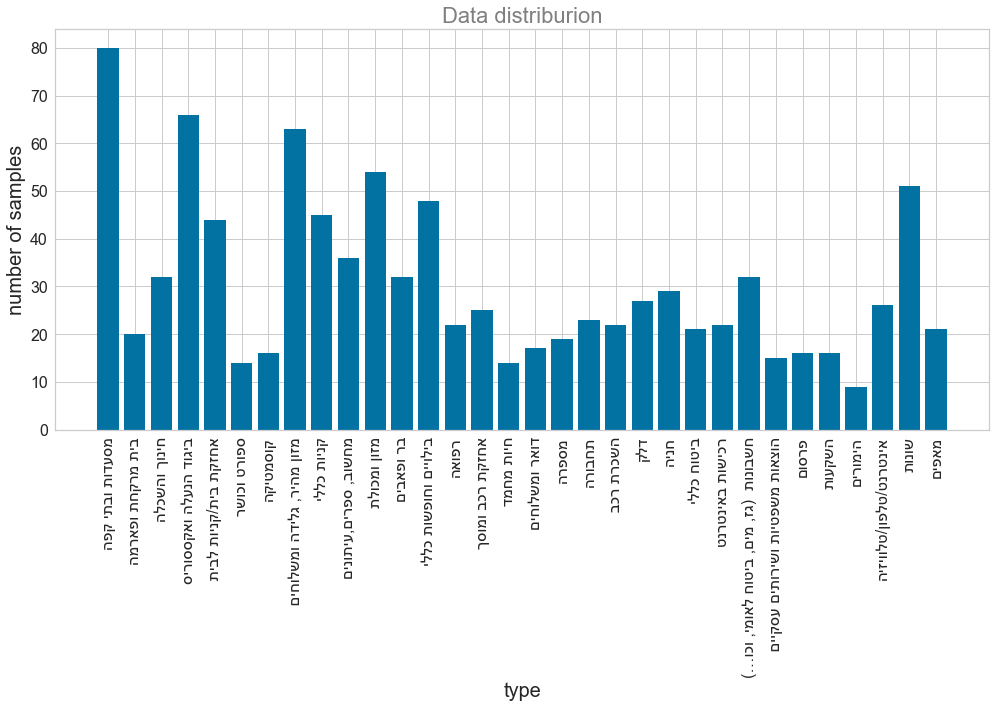

In [2]:
# Data distribution bar plot
types_distrib = companies_df['type'].value_counts()
plt.figure(figsize=(14,10))
plt.bar(types_distrib.index, types_distrib.values)
plt.title("Data distriburion", fontsize=22, color='Grey')
plt.xlabel("type", fontsize=20)
plt.ylabel("number of samples", fontsize=20)
plt.xticks(types_distrib.index, [from_id_to_name[id][::-1] for id in types_distrib.index], rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('./Data/Graphs/data-distribution', dpi=300)
plt.show()
plt.close('all')

In [4]:
# read scraped data from file 
with open('./Data/WebScrapping/all-companies-heb-only-without-comp-names-sw-cities.txt', 'r') as file:
    data = file.read()
    scrapped_text = data.split('//-1//')[:-1]
documents = np.asarray(scrapped_text)

In [5]:
# document sample after text preprocessing
documents[0]

'מאפייה מסלול יהושע פעילות ועוד בדפי זהב קונדיטוריות קונדיטוריות דפי זהב מציג מידע דפי זהב מסייע בקבלת החלטה צרכנית נבונה בתחום קונדיטוריות בית קפה ארוחות בוקר חלביות קונדיטוריה הפרטים קפה בית קפה המסעדות הישראלי ניתן לקרוא ביקורות גולשים ולהזמין מקום בקליק אביאל איזי קיים תיאור לעמוד לך להוסיף עדכון פרטי העסק הוספת ביקורת הוספת ביקורות מאפיהמקום לאכולקונדיטוריה דעתך הוספת עסקים עיקרי תגיות הזכויות שמורות עכשיו חשים קשורים מאפיית הכפר מאפייה מאפיות מאפיות מאפיות בפתח פתח דיווח שינויים בעסק בעקבות נגיף הקורונה מפה מסלול מפה מסלול מאפיות וקונדיטוריות דנסגייד מרכז דברי מאפה מאפיות וקונדיטוריות המידע שאתם צריכים מאפיות וקונדיטוריות היכנסו לדנסגייד מדריך העסקים המוביל מבית דן אנד ברדסטריט מאפית ומזנון תרי זוזי מאפית ומזנון עסקים מסעדות ומזון מאפיות וקונדיטוריות פרטי התקשרות להצגת המספר פקס צור קשר מאפית הכפר בד"ץ בית יוסף מאפית ומזנון פרטי העסק פתח פקס מפת הגעה דיווח בית עסק ביקרתם בבית עסק זה לכם הערה מתי המספר טרם עודכן קבלת קהל שעה סניפים סניפים סניפי מאפיית סניפי מפגש'

In [ ]:
# # split to (train/cross-validation) and test with ratio 90/10 and save indexes in file
# train_indices, test_indices = next(StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(documents, companies_types))
# with open('./Data/Training/test-train-split-indexes.pkl', 'wb') as file:
#     pickle.dump((train_indices, test_indices), file)

In [6]:
# read indexes of split from file
with open('./Data/Training/test-train-split-indexes.pkl', 'rb') as file:
    train_indices, test_indices = pickle.load(file)

documents_train, y_train = documents[train_indices], companies_types[train_indices]
documents_test, y_test = documents[test_indices], companies_types[test_indices]
companies_train, companies_test = companies[train_indices], companies[test_indices]

# check how many words each company's document have (min, mean)
company_doc_mean_len = sum(len(set(document.split(' '))) for document in documents)/len(documents)
company_doc_min_len = min(len(set(document.split(' '))) for document in documents)
print(f'The mean of company document length: \033[1m{company_doc_mean_len}\033[0m words')
print(f'The min of company document length: \033[1m{company_doc_min_len}\033[0m words')


# concatenate scraped text by types and save in dictionary
documents_by_types_dict = defaultdict(str)
for document, type_ in zip(documents_train, y_train):
    documents_by_types_dict[type_] += f'{document} '

    
# check how many words each type document have (min, mean)
mean_type_document_len = sum(len(set(doc.split(' '))) for doc in documents_by_types_dict.values()) / len(documents_by_types_dict)
min_type_document_len = min(len(set(doc.split(' '))) for doc in documents_by_types_dict.values())
print(f'The mean of type document length: \033[1m{mean_type_document_len}\033[0m words')
print(f'The min of type document length: \033[1m{min_type_document_len}\033[0m words')

The mean of company document length: 146.71545547594678 words
The min of company document length: 1 words
The mean of type document length: 2225.78125 words
The min of type document length: 930 words


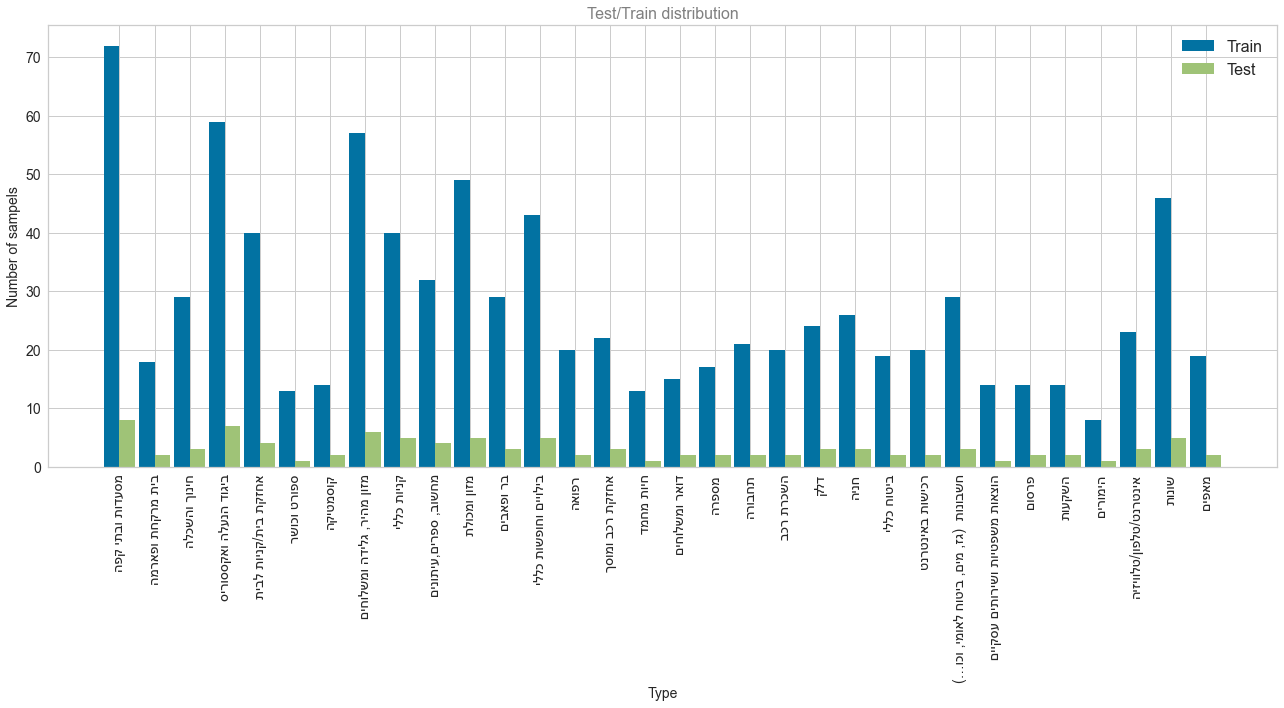

In [6]:
# test/train distribution bar plot
test_distrib = companies_df.iloc[test_indices]['type'].value_counts()
train_distrib = companies_df.iloc[train_indices]['type'].value_counts()
width = .45  # the width of the bars
plt.figure(figsize=(18, 10))
plt.bar(np.asarray(train_distrib.index), train_distrib.values, -width, align='edge', label='Train')
plt.bar(np.asarray(test_distrib.index), test_distrib.values, width, align='edge', label='Test')
plt.ylabel('Number of sampels', fontsize=14)
plt.xlabel('Type', fontsize=14)
plt.title('Test/Train distribution', color='Gray', fontsize=16)
plt.xticks(train_distrib.index, [from_id_to_name[id][::-1] for id in train_distrib.index], rotation='vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size': 16})
plt.tight_layout()
plt.savefig('./Data/Graphs/train-test-distribution', dpi=300)
plt.show()
plt.close('all')


In [7]:
# ====== calculate TF-IDF with TfidfVectorizer for train and cross validation  =======

X_train, idf = create_tfidf(documents_train, companies_train)
idf.to_csv('./Data/Training/idf-all-words.csv')
X_train.to_csv('./Data/Training/tf-idf-all-words.csv')

print(f'The number of features in train data is: \033[1m{idf.size}\033[0m features')

The number of features in train data is: 26623 features


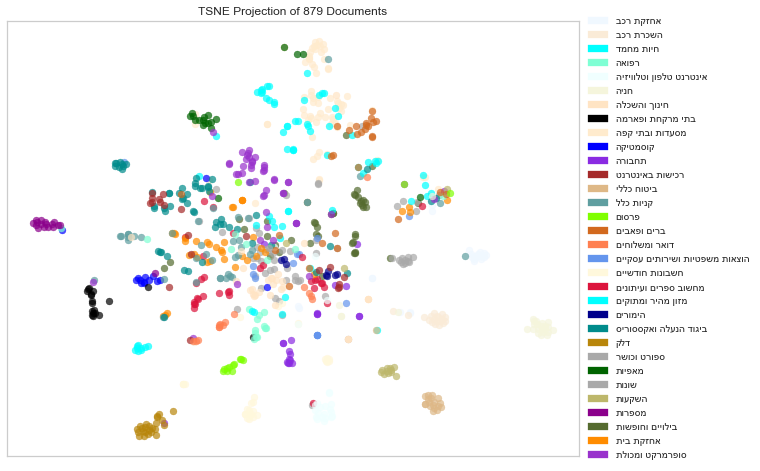

<AxesSubplot:title={'center':'TSNE Projection of 879 Documents'}>

In [8]:
# visualaze tf-idf data
from matplotlib import colors
plt.figure(figsize=(16, 8))
viz = TSNEVisualizer(alpha = 0.7, colors=list(colors.CSS4_COLORS.keys())[:32])
viz.fit(X_train,[from_id_to_name[type_][::-1] for type_ in y_train])
viz.show(outpath="./Data/Graphs/data-visualizatoin.png")
viz.poof()

<div stype="text-align: left;"><h1>model selection </h1></div>

In [9]:
def fit_defoult(estimator, X_train, y_train):
    scores = []
    X_train = np.asarray(X_train)
    for train, test in StratifiedKFold().split(X_train, y_train):
        curr_X_train, curr_X_test = X_train[train], X_train[test]
        curr_y_train, curr_y_test = y_train[train], y_train[test]
        scores.append(estimator.fit(curr_X_train, curr_y_train).score(curr_X_test, curr_y_test))
    print(f'\033[1m{estimator.__class__.__name__}\033[0m: {np.mean(scores)}')
    
def parameter_tuning(estimator, X_train, y_train, params):
    gs = GridSearchCV(estimator, params, cv=StratifiedKFold(), return_train_score=True, n_jobs=-1)
    gs_results = gs.fit(X_train, y_train)
    best_index = gs_results.best_index_
    print(f'\033[1m{estimator.__class__.__name__}\033[0m:\n'
          f'  best params:{gs_results.best_params_}\n'
          f'  mean-accuracy: {gs_results.best_score_}\n'
          f'  train-mean-accuracy: {gs_results.cv_results_["mean_train_score"][best_index]}\n')
    return gs_results


In [10]:
print('Mean accuracy (5-Fold)')
print('-'*100)
fit_defoult(KNeighborsClassifier(metric='cosine'), X_train, y_train)
fit_defoult(LogisticRegression(), X_train, y_train)
fit_defoult(MultinomialNB(), X_train, y_train)
print('-'*100)

Mean accuracy (5-Fold)
----------------------------------------------------------------------------------------------------
KNeighborsClassifier: 0.6928376623376623
LogisticRegression: 0.5813701298701298
MultinomialNB: 0.3936363636363637
----------------------------------------------------------------------------------------------------


In [11]:
print('-'*100)
nb_params = {'fit_prior': [True, False],'alpha': [10**x for x in range(-9, 1)]}
lg_params = {"C":np.logspace(-3,3,7), "penalty":["l2"], 'multi_class': ['ovr']}
knn_params = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 19], 'weights': ['uniform', 'distance']}
knn_results = parameter_tuning(KNeighborsClassifier(metric='cosine'), X_train, y_train, knn_params)
lg_results = parameter_tuning(LogisticRegression(), X_train, y_train, lg_params)
nb_results = parameter_tuning(MultinomialNB(), X_train, y_train, nb_params)
print('-'*100)

----------------------------------------------------------------------------------------------------
KNeighborsClassifier:
  best params:{'n_neighbors': 9, 'weights': 'distance'}
  mean-accuracy: 0.7144350649350649
  train-mean-accuracy: 0.9988624240268976

LogisticRegression:
  best params:{'C': 100.0, 'multi_class': 'ovr', 'penalty': 'l2'}
  mean-accuracy: 0.7349415584415585
  train-mean-accuracy: 1.0

MultinomialNB:
  best params:{'alpha': 0.1, 'fit_prior': False}
  mean-accuracy: 0.7394545454545455
  train-mean-accuracy: 0.990898179878443

----------------------------------------------------------------------------------------------------


In [12]:

# functions for cross validation and feature selection
def cv_feature_select_tfidf(estimator, params, X_train, y_train, idf, cv):
    n_words_scores = {} # { num_of_words: score, num_of_features }
    
    for nbest in range(5, 151, 5):
        print(nbest)
        nbest_X_train, nbest_idf = tf_idf_nbest_feature_selection(X_train, idf, nbest)
        curr_X_train = np.asarray(nbest_X_train)
        
        grid_cv = GridSearchCV(estimator, param_grid=params, return_train_score=True, cv=cv, n_jobs=-1)
        grid_cv_results = grid_cv.fit(curr_X_train, y_train)

        
        n_words_scores[nbest] = grid_cv_results, len(nbest_X_train.columns), nbest_idf
        clear_output(wait = True)
    return n_words_scores



def cv_features_select_chi(estimator, params, X_train, y_train, cv):
    chi_scores = {}
    for kbest in range(2000, 27000, 500):
        print(kbest)
        k_best = SelectKBest(chi2, k=kbest)
        x_k_best = k_best.fit_transform(X_train, y_train)
        features_support = k_best.get_support()
        best_features = [feature for isin, feature in zip(features_support, X_train.columns) if isin]

        gs = GridSearchCV(estimator, params, cv=cv, n_jobs=-1)
        gs_results = gs.fit(x_k_best, y_train)
        
        chi_scores[kbest] = gs_results, best_features
        clear_output(wait = True)
    return chi_scores
    

In [13]:
# גרפים עבור צמצום פיצ'רים על ידי טפ אידיפ הכי טוב
def dots_plot(x, y, title='dots plot', ylabel='y', xlabel='x', fig_size=(14, 7), xticks=None, path_to_save=None, xtick_rotation=None, y_lim=None):
    plt.figure(figsize=fig_size)
    if y_lim:
        plt.ylim(y_lim)
    plt.plot(x, y, 'o-')
    plt.title(title, fontsize=22, color='Grey')
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    if xticks:
        plt.xticks(xticks , rotation=xtick_rotation, fontsize=14)
    plt.yticks(fontsize=14)
   
    if path_to_save:
        plt.tight_layout()
        plt.savefig(path_to_save, dpi=300)
    plt.show()
        
    plt.close('all')


def bar_plot(x, y, title='bar plot', xlabel='x', ylabel='y', fig_size=(14, 7), path_to_save=None):
    plt.figure(figsize=fig_size)
    plt.bar(x, y, width=25, tick_label=x)
    plt.xticks(fontsize=14, rotation='vertical')
    plt.yticks(fontsize=14)
    plt.title(title, fontsize=22, color='Grey')
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    if path_to_save:
        plt.tight_layout()
        plt.savefig(path_to_save, dpi=300)
    plt.show()
        
    plt.close('all')

In [16]:
def plot_learning_curve(estimator, X, y, cv, title='learning curve', path_to_save=None):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, n_jobs=-1, cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(10, 6))
    plt.title(title, fontsize=14, color='Gray')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                         color="#ff9124")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                         color="#2492ff")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
    plt.title(title, fontsize=14, color='Gray')
    plt.ylim((0, 1.05))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Training size (m)')
    plt.ylabel('Accuracy Score')
    plt.grid(True)
    plt.legend(loc="lower right")
    if path_to_save:
        plt.tight_layout()
        plt.savefig(path_to_save, dpi=300)
    plt.show()
    plt.close('all')

In [18]:
# check scores for Naive Bayes with n best words with highest tf-idf index in vector 
nwords_scores_nb = cv_feature_select_tfidf(MultinomialNB(), nb_params, X_train, y_train, idf, skf)

with open('./Models/Feature-Selection/nwards-scores-nb.pkl', 'wb') as file:
    pickle.dump(nwords_scores_nb, file)
    


150


Best 5 feature selections(best_words_per_document(number_of_featues): score):
  20(8620): 0.7565324675324675
  15(6840): 0.7519805194805195
  25(10452): 0.7519805194805195
  45(19558): 0.7519805194805195
  10(4778): 0.751961038961039


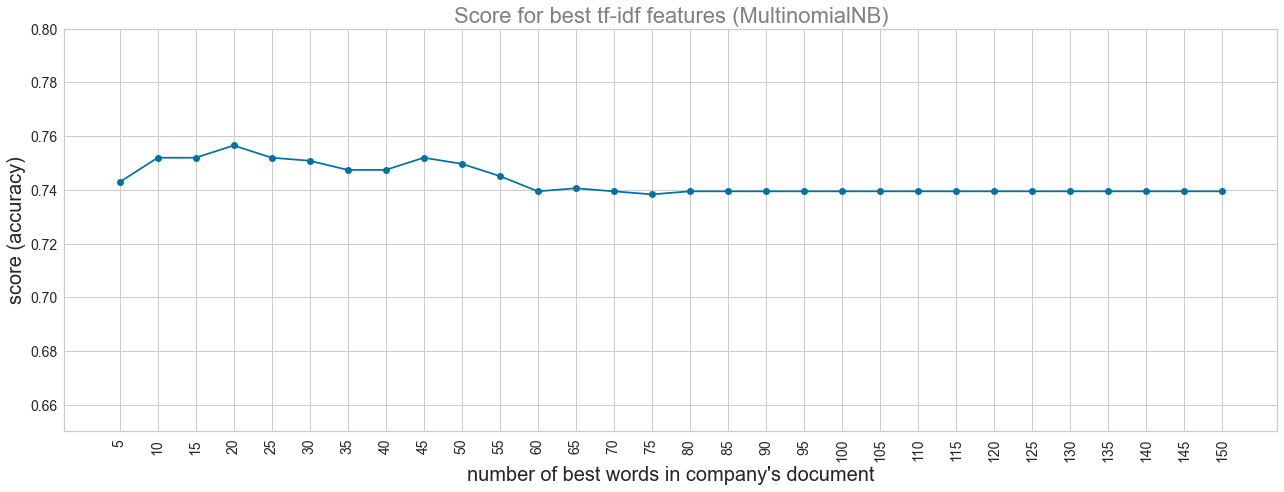

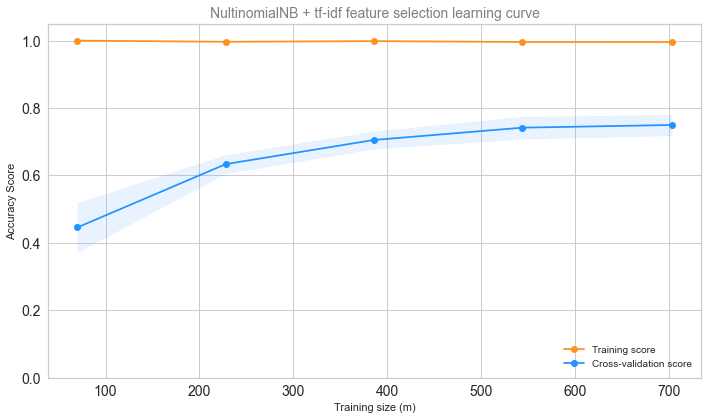

In [20]:
with open('./Models/Feature-Selection/nwords-scores-nb.pkl', 'rb') as file:
    nwords_scores_nb = pickle.load(file)
    

# print 5 best results (number_of_features: score)
print('Best 5 feature selections(best_words_per_document(number_of_featues): score):')
for k, v in [(key,(value[0].best_score_, value[1])) for key, value in sorted(nwords_scores_nb.items(), key=lambda x: x[1][0].best_score_, reverse=True)][:5]:
    print(f'  \033[1m{k}({v[1]})\033[0m: \033[4m{v[0]}\033[0m')


dots_plot(list(nwords_scores_nb.keys()), [value[0].best_score_ for value in nwords_scores_nb.values()], title='Score for best tf-idf features (MultinomialNB)',
          xlabel="number of best words in company's document", ylabel='score (accuracy)', fig_size=(18, 7), y_lim=(0.65, 0.8),
          xticks=list(range(5, 151, 5)), xtick_rotation='vertical', 
          path_to_save='./Data/Graphs/Score-for-best-tf-idf-features-nb.png')


plot_learning_curve(nwords_scores_nb[20][0], X_train[nwords_scores_nb[20][2].index.tolist()], y_train,
                    title='NultinomialNB + tf-idf feature selection learning curve', cv=skf,
                    path_to_save='./Data/Graphs/nwords-nb-learning-curve.png')

In [21]:
# feature selection chi2, naive bayes  
chi_scores_nb = cv_features_select_chi(MultinomialNB(), nb_params, X_train, y_train, skf)
with open('./Models/Feature-Selection/chi-scores-nb.pkl', 'wb') as file:
    pickle.dump(chi_scores_nb, file)

26500


Best 5 feature selections(number_of_features: score):
  8500: 0.7724545454545455
  2500: 0.7701623376623377
  9000: 0.7690454545454546
  9500: 0.7690454545454546
  10000: 0.7690389610389612


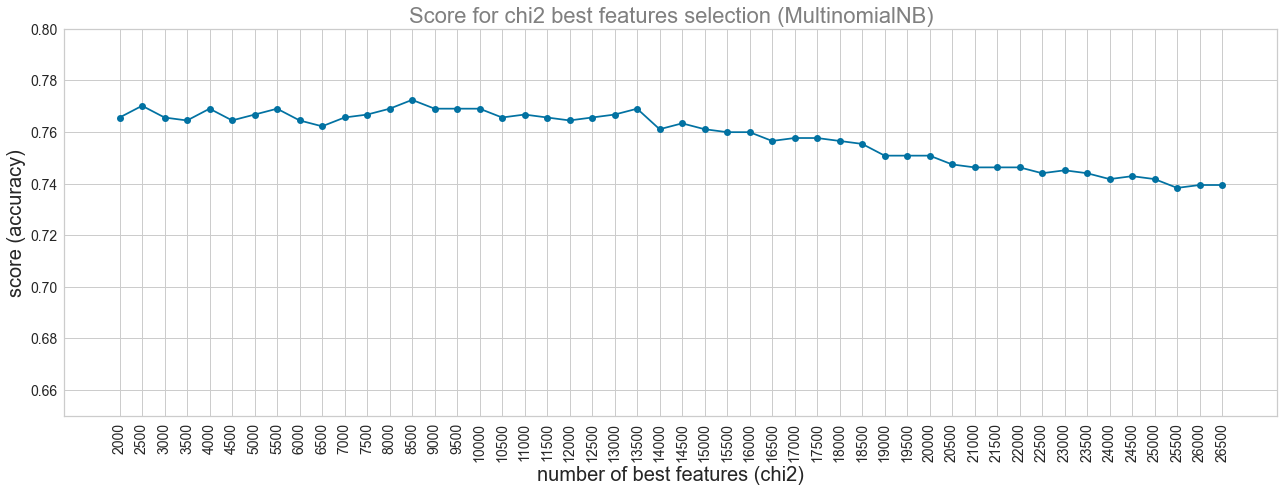

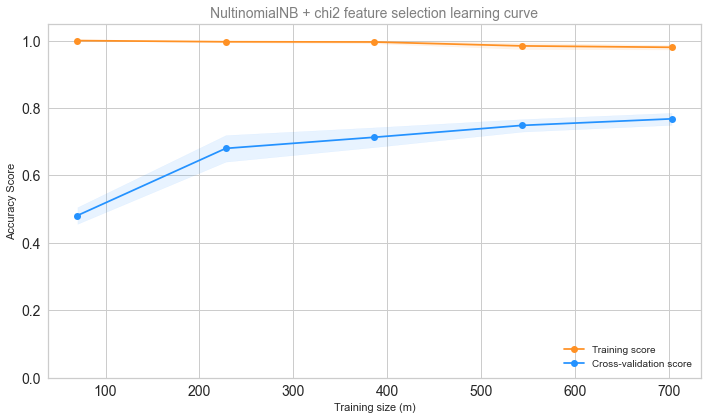

In [22]:
with open('./Models/Feature-Selection/chi-scores-nb.pkl', 'rb') as file:
    chi_scores_nb = pickle.load(file)
    
    
# print 5 best results (number_of_features: score)
print('Best 5 feature selections(number_of_features: score):')
for k, v in [(key,value[0].best_score_) for key, value in sorted(chi_scores_nb.items(), key=lambda x: x[1][0].best_score_, reverse=True)][:5]:
    print(f'  \033[1m{k}\033[0m: \033[4m{v}\033[0m')
    
    
dots_plot(list(chi_scores_nb.keys()), [value[0].best_score_ for value in chi_scores_nb.values()], title='Score for chi2 best features selection (MultinomialNB)',
          xlabel='number of best features (chi2)', ylabel='score (accuracy)', 
          fig_size=(18, 7),y_lim=(0.65, 0.8), xticks=list(range(2000, 27000, 500)), xtick_rotation='vertical',
          path_to_save='./Data/Graphs/Score-for-best-chi-features-nb.png')

plot_learning_curve(chi_scores_nb[8500][0], X_train[chi_scores_nb[8500][1]], y_train,
                    title='NultinomialNB + chi2 feature selection learning curve', 
                    cv=skf, path_to_save='./Data/Graphs/chi2-nb-learning-curve.png')


In [33]:
# knn select best features by tf-idf
nwords_scores_knn = cv_feature_select_tfidf(KNeighborsClassifier(metric='cosine'), knn_params, X_train, y_train, idf, skf)
    
with open('./Models/Feature-Selection/nwords-scores-knn.pkl', 'wb') as file:
    pickle.dump(nwords_scores_knn, file)


150


Best 5 feature selections(best_words_per_documet(number_of_features): score):
  20(8620): 0.715577922077922
  25(10452): 0.715577922077922
  10(4778): 0.7144480519480519
  30(12585): 0.7144480519480519
  60(24146): 0.7144415584415584


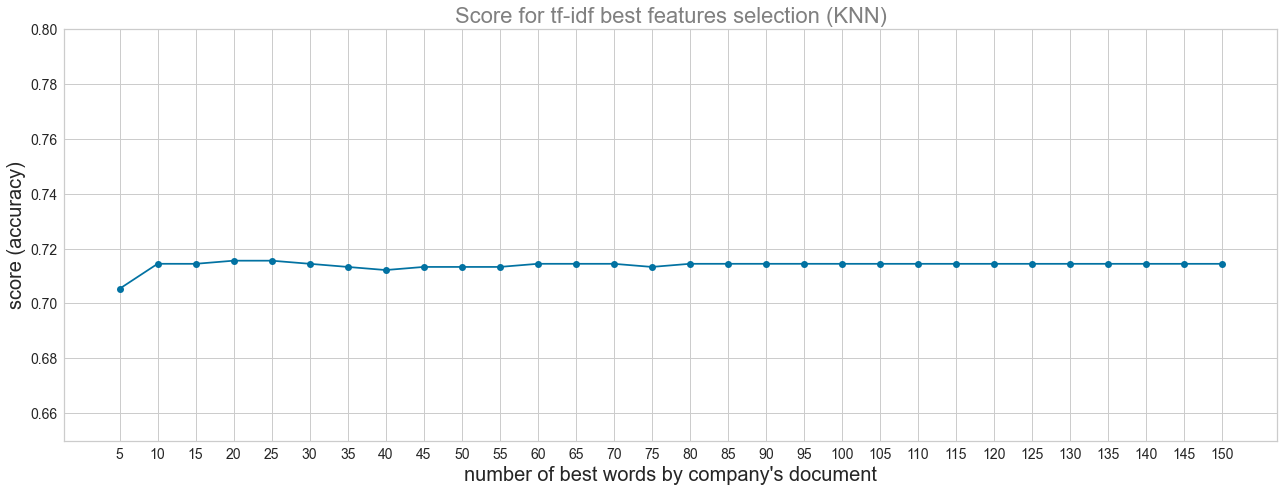

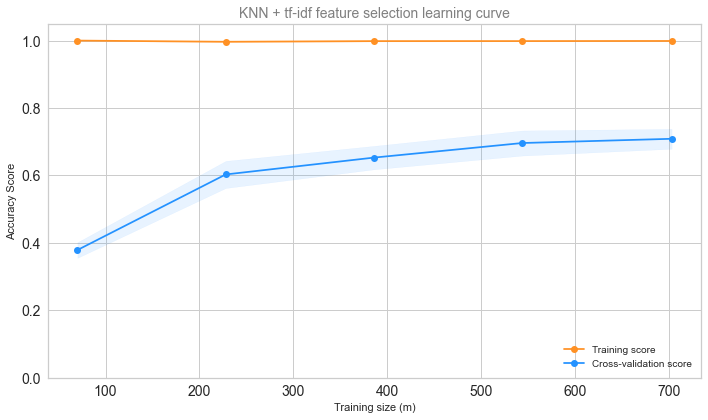

In [34]:

with open('./Models/Feature-Selection/nwords-scores-knn.pkl', 'rb') as file:
    nwords_scores_knn = pickle.load(file)
    

# print 5 best results (number_of_features: score)
print('Best 5 feature selections(best_words_per_documet(number_of_features): score):')
for k, v in [(key,(value[0].best_score_, value[1])) for key, value in sorted(nwords_scores_knn.items(), key=lambda x: x[1][0].best_score_, reverse=True)][:5]:
    print(f'  \033[1m{k}({v[1]})\033[0m: \033[4m{v[0]}\033[0m')


dots_plot(list(nwords_scores_knn.keys()), [value[0].best_score_ for value in nwords_scores_knn.values()], title='Score for tf-idf best features selection (KNN)',
          xlabel="number of best words by company's document", ylabel='score (accuracy)', 
          fig_size=(18, 7), y_lim=(0.65, 0.8), xticks=list(range(5, 151, 5)),
          path_to_save='./Data/Graphs/Score-for-best-tf-idf-features-knn.png')


plot_learning_curve(nwords_scores_knn[20][0], X_train[nwords_scores_knn[20][2].index.tolist()], y_train,
                    title='KNN + tf-idf feature selection learning curve', 
                    cv=skf, path_to_save='./Data/Graphs/nwords-knn-learning-curve.png')

In [39]:
# knn select best features by chi2
chi_scores_knn = cv_features_select_chi(KNeighborsClassifier(metric='cosine'), knn_params, X_train, y_train, skf)
    
with open('./Models/Feature-Selection/chi-scores-knn.pkl', 'wb') as file:
    pickle.dump(chi_scores_knn, file)

26500


Best 5 feature selections(number_of_features: score):
  2500: 0.719
  2000: 0.7178376623376622
  3000: 0.7167207792207793
  5000: 0.7167207792207793
  15000: 0.7155779220779221


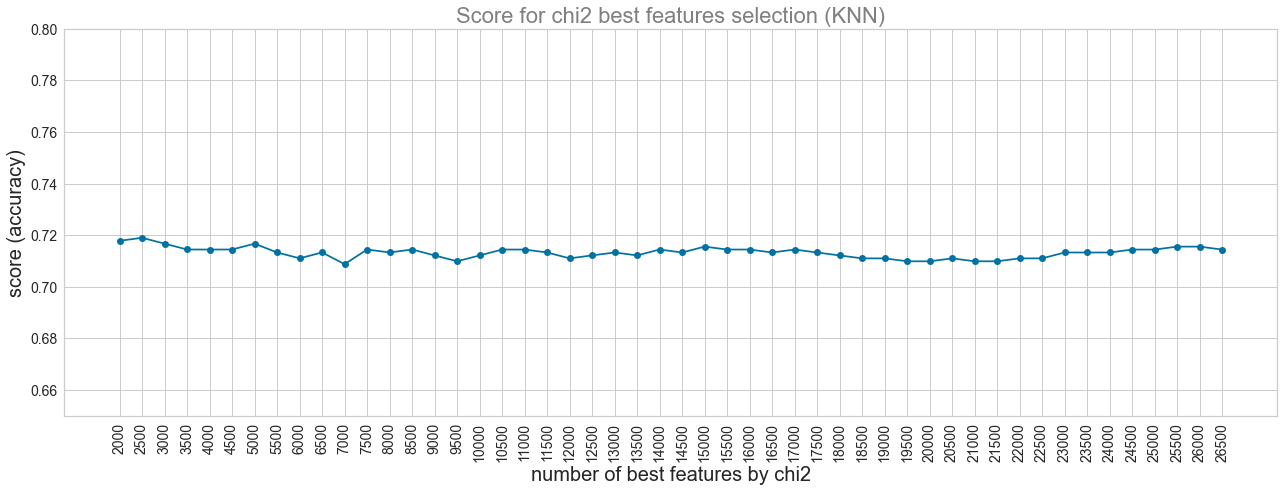

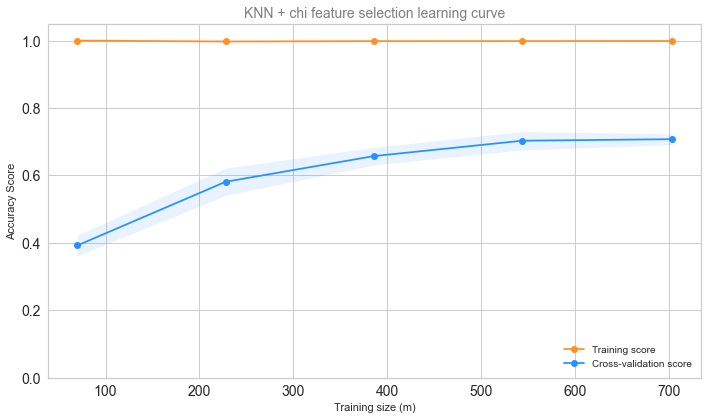

In [41]:

with open('./Models/Feature-Selection/chi-scores-knn.pkl', 'rb') as file:
    chi_scores_knn = pickle.load(file)

    
# print 5 best results (number_of_features: score)
print('Best 5 feature selections(number_of_features: score):')
for k, v in [(key,value[0].best_score_) for key, value in sorted(chi_scores_knn.items(), key=lambda x: x[1][0].best_score_, reverse=True)][:5]:
    print(f'  \033[1m{k}\033[0m: \033[4m{v}\033[0m')
    


dots_plot(list(chi_scores_knn.keys()), [value[0].best_score_ for value in chi_scores_knn.values()], title='Score for chi2 best features selection (KNN)',
          xlabel="number of best features by chi2", ylabel='score (accuracy)', 
          fig_size=(18, 7), y_lim=(0.65, 0.8), xticks=list(range(2000, 27000, 500)), xtick_rotation='vertical',
          path_to_save='./Data/Graphs/Score-for-best-chi-features-nb.png')

plot_learning_curve(chi_scores_knn[2500][0], X_train[chi_scores_knn[2500][1]], y_train,
                    title='KNN + chi feature selection learning curve', 
                    cv=skf, path_to_save='./Data/Graphs/chi2-knn-learning-curve.png')

In [42]:
# KNN with n_neighbors=1 and train on tf-idf from types documents
tf_idf_by_type_df, idf_by_type_df = create_tfidf(list(documents_by_types_dict.values()), list(documents_by_types_dict.keys()))

scores = []
    
for train_index, test_index in skf.split(documents_train, y_train):
    
    curr_documents_train, curr_documents_test = documents_train[train_index], documents_train[test_index]
    curr_y_train, curr_y_test = y_train[train_index], y_train[test_index]

    curr_documents_by_type = defaultdict(str)
    for doc, t in zip(curr_documents_train, curr_y_train):
        curr_documents_by_type[t] += f'{doc} '

    # create tf-idf vectorizer from k-fold train split    
    curr_tf_idf_df, curr_idf_df = create_tfidf(list(curr_documents_by_type.values()), list(curr_documents_by_type.keys()))

    # create tf-idf for cross-validation split
    curr_X_test = create_test_tf_idf(curr_documents_test, curr_idf_df['idf'], curr_idf_df.index.tolist())

    model = KNeighborsClassifier(n_neighbors=1, metric='cosine').fit(curr_tf_idf_df, curr_tf_idf_df.index)
    scores.append(model.score(curr_X_test, curr_y_test))

print(f'accuracy: {np.mean(scores)}')

accuracy: 0.7531233766233766


In [49]:
# KNN with n_neighbors=1 and train on tf-idf from types documents feature selection by words with highest tf-idf
# The number of uniqe words per type is about 2440 words and the minimum length is 1143 words
by_type_scores = {}

for num_of_words in range(20, 2000, 40):
    
    print(num_of_words)
    # select features by best words from type's document
    nbest_tf_idf_df, nbest_idf_df = tf_idf_nbest_feature_selection(tf_idf_by_type_df, idf_by_type_df, num_of_words)
    
    scores, words = [], []
    
    for train_index, test_index in skf.split(documents_train, y_train):
        curr_documents_train, curr_documents_test = documents_train[train_index], documents_train[test_index]
        curr_y_train, curr_y_test = y_train[train_index], y_train[test_index]
        
        curr_documents_by_type = defaultdict(str)
        for doc, t in zip(curr_documents_train, curr_y_train):
            curr_documents_by_type[t] += f'{doc} '
            
        # create tf-idf vectorizer from k-fold train split    
        curr_tf_idf_df, curr_idf_df = create_tfidf(list(curr_documents_by_type.values()), list(curr_documents_by_type.keys()))
        
        # select best features in tf-idf
        curr_nbest_tf_idf_df, curr_nbest_idf_df = tf_idf_nbest_feature_selection(curr_tf_idf_df, curr_idf_df, num_of_words)
        
        # create tf-idf for cross-validation split
        curr_X_test = create_test_tf_idf(curr_documents_test, curr_nbest_idf_df['idf'], curr_nbest_idf_df.index.tolist())
        
        model = KNeighborsClassifier(n_neighbors=1, metric='cosine').fit(curr_nbest_tf_idf_df, curr_nbest_tf_idf_df.index)
        scores.append(model.score(curr_X_test, curr_y_test))
    
    by_type_scores[num_of_words] = scores, nbest_idf_df, KNeighborsClassifier(n_neighbors=1,
                                                        metric='cosine').fit(nbest_tf_idf_df, nbest_tf_idf_df.index)
    clear_output(wait = True)

with open('./Models/by-type-scores.pkl', 'wb') as file:
    pickle.dump(by_type_scores, file)

1980


Best 11 feature selections(number_of_features: score):
  1060: 0.7439935064935066
  1100: 0.7439935064935066
  1140: 0.7439935064935066
  1180: 0.7439935064935066
  1220: 0.7439935064935066
  1260: 0.7439935064935066
  1300: 0.7439935064935066
  1340: 0.7439935064935066
  1380: 0.7439935064935066
  1420: 0.7439935064935066
  420: 0.7428571428571429


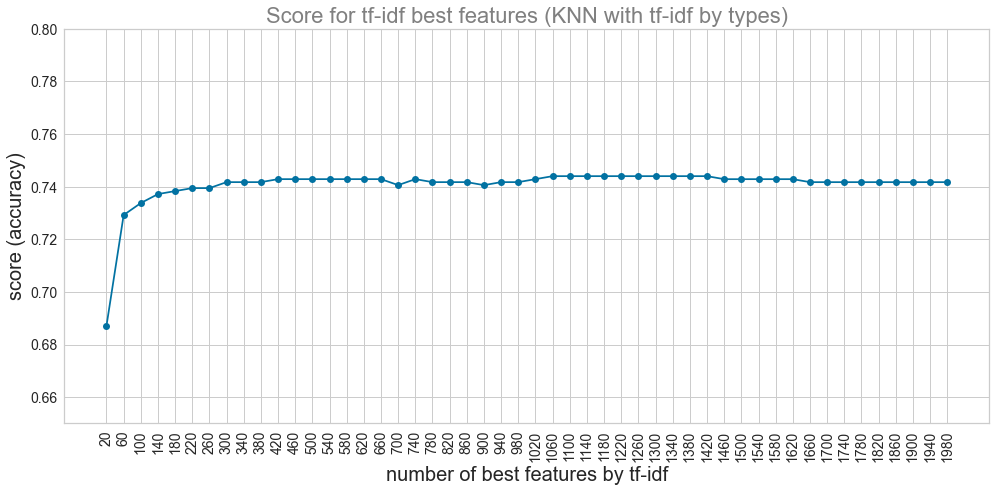

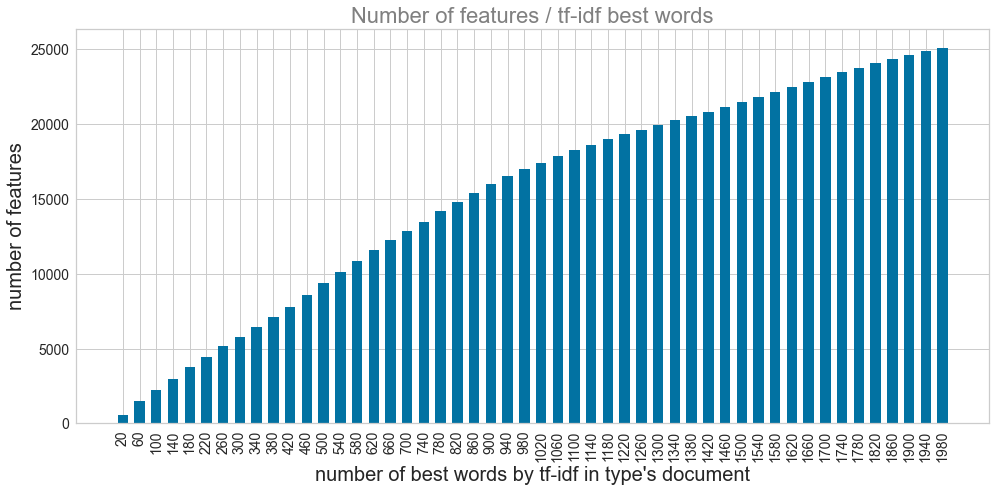

In [50]:

with open('./Models/by-type-scores.pkl', 'rb') as file:
    type_scores = pickle.load(file)
    

# print 11 best results (number_of_features: score)
print('Best 11 feature selections(number_of_features: score):')
for k, v in [(key,np.mean(value[0])) for key, value in sorted(type_scores.items(), key=lambda x: np.mean(x[1][0]), reverse=True)][:11]:
    print(f'  \033[1m{k}\033[0m: \033[4m{v}\033[0m')

    
dots_plot(x=list(type_scores.keys()), y=[np.mean(value[0]) for value in type_scores.values()],
          title='Score for tf-idf best features (KNN with tf-idf by types)', xlabel='number of best features by tf-idf', ylabel='score (accuracy)', 
          y_lim=(0.65, 0.8), xticks=list(range(20, 2000, 40)), xtick_rotation='vertical',
          path_to_save='./Data/Graphs/knn-by-types-best-feature.png')


bar_plot(list(type_scores.keys()), [value[1].size for value in type_scores.values()], 
         title='Number of features / tf-idf best words', xlabel="number of best words by tf-idf in type's document", 
         ylabel='number of features', path_to_save='./Data/Graphs/num-of-feature-by-best-words.png')




In [54]:
# PCA dimensionality reduction with Logistic Regression
lg_pca = make_pipeline(PCA(), LogisticRegression(**lg_results.best_params_))

log_reg_pca_params = {'pca__n_components' : [50, 100, 150, 200]}
lg_cv = GridSearchCV(lg_pca, param_grid=log_reg_pca_params, cv=StratifiedKFold()).fit(X_train, y_train)


number of features: mean cross-validation score
50: 0.6621428571428571
100: 0.7212662337662338
150: 0.7314805194805195
200: 0.7440064935064935


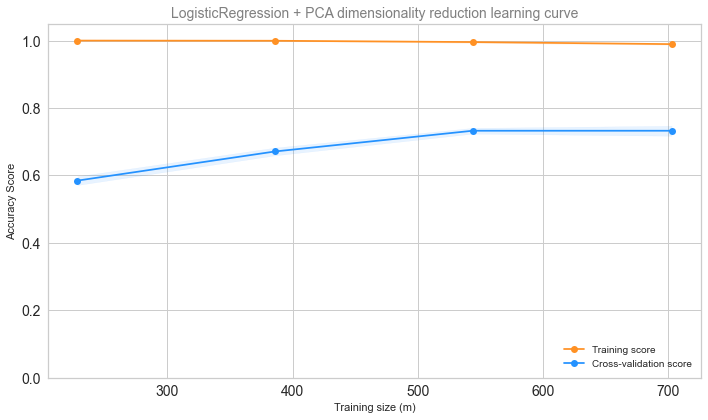

In [55]:
with open('./Models/lg_pca.pkl', 'wb') as file:
    pickle.dump(lg_cv.best_estimator_, file)

# number of features and mean cross-validation score
print('number of features: mean cross-validation score')
for features, score in zip(lg_cv.cv_results_['param_pca__n_components'], lg_cv.cv_results_['mean_test_score']): 
    print(f'\033[1m{features}\033[0m: {score}')


plot_learning_curve(lg_cv.best_estimator_, X_train, y_train,
                    title='LogisticRegression + PCA dimensionality reduction learning curve', 
                    cv=skf, path_to_save='./Data/Graphs/lg-pca-learning-curve.png')

In [23]:
types_list_extend = pd.read_excel('./Data/Training/types-list.xlsx')
types_list_extend['type_extended_id'] = types_list_extend['type_extended_id'].astype('str')
type_to_extend = {row['type_id']: list(map(int, row['type_extended_id'].split(','))) for i, row in types_list_extend.iterrows()}

def smooth_score(pred, y_test):
    type_to_extend = {row['type_id']: list(map(int, row['type_extended_id'].split(','))) for i, row in types_list_extend.iterrows()}
    tp = 0
    for pred_i, y_test_i in zip(pred, y_test):
        if pred_i in type_to_extend[y_test_i]:
            tp += 1
    return tp / len(y_test)
            

In [56]:
X_test_chi_nb = create_test_tf_idf(documents_test, idf.loc[chi_scores_nb[8500][1]]['idf'], chi_scores_nb[8500][1])
X_test_chi_knn = create_test_tf_idf(documents_test, idf.loc[chi_scores_knn[2500][1]]['idf'], chi_scores_nb[2500][1])
X_test_nwords_nb = create_test_tf_idf(documents_test, nwords_scores_nb[20][2]['idf'], nwords_scores_nb[20][2].index.tolist())
X_test_nwords_knn = create_test_tf_idf(documents_test, nwords_scores_knn[20][2]['idf'], nwords_scores_knn[20][2].index.tolist())
X_test_knn_by_types = create_test_tf_idf(documents_test, type_scores[420][1]['idf'], type_scores[420][1].index.tolist())
X_test_lg_pca = create_test_tf_idf(documents_test, idf['idf'], idf.index.tolist())


chi_nb_pred = chi_scores_nb[8500][0].best_estimator_.predict(X_test_chi_nb)
chi_nb_pred_proba = chi_scores_nb[8500][0].best_estimator_.predict_proba(X_test_chi_nb)

knn_by_types_pred = type_scores[420][2].predict(X_test_knn_by_types)
knn_by_types_pred_proba = type_scores[420][2].predict_proba(X_test_knn_by_types)

nwords_nb_pred = nwords_scores_nb[20][0].best_estimator_.predict(X_test_nwords_nb)
nwords_nb_pred_proba = nwords_scores_nb[20][0].best_estimator_.predict_proba(X_test_nwords_nb)

nwords_knn_pred = nwords_scores_nb[20][0].best_estimator_.predict(X_test_nwords_knn)
nwords_knn_pred_proba = nwords_scores_nb[20][0].best_estimator_.predict_proba(X_test_nwords_knn)

lg_pca_pred = lg_cv.best_estimator_.predict(X_test_lg_pca)
lg_pca_pred_proba = lg_cv.best_estimator_.predict_proba(X_test_lg_pca)

chi_knn_pred = chi_scores_knn[2500][0].best_estimator_.predict(X_test_chi_knn)
chi_knn_pred_proba = chi_scores_knn[2500][0].best_estimator_.predict_proba(X_test_chi_knn)
estimators = {'MultinomialNB + Chi2': (chi_nb_pred, chi_nb_pred_proba), 'KNN + Chi2': (chi_knn_pred, chi_knn_pred_proba),
              'KNN + tf-idf by types': (knn_by_types_pred, knn_by_types_pred_proba), 'KNN + tf-idf best words': (nwords_knn_pred, nwords_knn_pred_proba),
              'MultinomialNB + tf-idf best words': (nwords_nb_pred, nwords_nb_pred_proba), 'LogisticRegression + PCA': (lg_pca_pred, chi_knn_pred_proba)
             }

In [24]:

def classif_report(estimators, y_test):
    accuracy, f1, precision, recall, auc, smooth_accuracy = [], [], [], [], [], []
    
    for pred, proba in estimators.values():
        f1.append('{:.4f}'.format(f1_score(y_test, pred, average='macro')))
        accuracy.append('{:.4f}'.format(accuracy_score(y_test, pred)))
        precision.append('{:.4f}'.format(precision_score(y_test, pred, average='macro')))
        recall.append('{:.4f}'.format(recall_score(y_test, pred, average='macro')))
        auc.append('{:.4f}'.format(roc_auc_score(y_test, proba, average='macro', multi_class='ovr')))
        smooth_accuracy.append(('{:.4f}'.format(smooth_score(pred, y_test))))
    return pd.DataFrame({'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall, 'auc': auc, 'smooth_accuracy': smooth_accuracy }, index=list(estimators.keys()))


In [57]:
classif_report(estimators, y_test)

,accuracy,f1_score,precision,recall,auc,smooth_accuracy
MultinomialNB + Chi2,0.7653,0.7315,0.7403,0.7487,0.9680,0.8163
KNN + Chi2,0.7347,0.7391,0.7573,0.7481,0.9462,0.7959
KNN + tf-idf by types,0.7347,0.7285,0.7482,0.7543,0.8728,0.7857
KNN + tf-idf best words,0.7347,0.7157,0.7362,0.7252,0.9646,0.7857
MultinomialNB + tf-idf best words,0.7347,0.7157,0.7362,0.7252,0.9646,0.7857
LogisticRegression + PCA,0.7449,0.7044,0.7305,0.7132,0.9462,0.8163
